# Mix-up on Multi-label Learning


## Preparation

### import package

In [1]:
import numpy as np
import scipy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import random
from leemultilearn.utils.convert import to_ndarray
from leemultilearn.utils.random import seed
from leemultilearn.dataset import available_datasets, MllDataset
from leemultilearn.metrics import (
    hamming_loss,
    label_ranking_loss,
    average_precision_score,
    coverage_error,
    one_error,
)
from tqdm.notebook import tqdm
import copy

In [2]:
seed(42)

### train

In [277]:
def train_epoch(model, dataloader, criterion, optimizer, device='cpu', mixup=False, alpha=0.2):
    model.train()
    epoch_loss = []
        
    for X, Y in dataloader:
        X, Y = X.to(device), Y.to(device)
        Y = Y.squeeze().to(torch.float32)
        
        X.requires_grad = False
        Y.requires_grad = False

        # print(f'{next(model.parameters()).device = }')
        # print(f'{device = }')
        
        if mixup:
            # Mixup inputs.
            lambda_ = np.random.beta(alpha, alpha)
            idxs = torch.randperm(X.size(0))
            mixed_X = lambda_ * X + (1 - lambda_) * X[idxs, :]

            # Mixup loss.
            Y_pred = model(X)
            loss = lambda_ * criterion(Y_pred, Y) + (1 - lambda_) * criterion(Y_pred, Y[idxs, :])

        else:
            # no Mixup
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

### test

In [4]:
# multi-label evaluation
def evaluate(y_test, y_pred, y_pred_proba):
    y_test = to_ndarray(y_test)
    y_pred = to_ndarray(y_pred)
    y_pred_proba = to_ndarray(y_pred_proba)
    
    return (
        hamming_loss(y_test, y_pred), 
        label_ranking_loss(y_test, y_pred_proba), 
        coverage_error(y_test, y_pred_proba), 
        one_error(y_test, y_pred_proba), 
        average_precision_score(y_test, y_pred_proba), 
    )

def print_evaluation(hamming_loss, label_ranking_loss, coverage_error, one_error, average_precision_score):
    print('%15s: %.4f' % ('hamming_loss', hamming_loss))
    print('%15s: %.4f' % ('ranking_loss', label_ranking_loss))
    print('%15s: %.4f' % ('coverage_error', coverage_error))
    print('%15s: %.4f' % ('one_error', one_error))
    print('%15s: %.4f' % ('avg_precision', average_precision_score))

In [274]:
def evaluate_epoch(model, dataloader, criterion, device='cpu'):
    model.eval()
    epoch_loss = []
    epoch_evaluation = []
    
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            Y = Y.squeeze().to(torch.float32)

            Y_pred = model(X)

            loss = criterion(Y_pred, Y)
            epoch_loss.append(loss.item())

            Y = Y.cpu().squeeze().numpy()
            Y_pred = Y_pred.cpu().detach().squeeze().numpy()
            Y_cls = Y_pred > 0.5
            evaluation = evaluate(Y, Y_cls, Y_pred)
            epoch_evaluation.append(evaluation)
    
    return np.mean(epoch_loss), np.mean(epoch_evaluation, axis=0)

In [48]:
def evaluate_epoch_rescaled(model, test_dataloader, train_dataloader, criterion, device='cpu', alpha=0.2):
    model.eval()
    epoch_loss = []
    epoch_evaluation = []
    
    theta_bar = 1.0 - scipy.special.betainc(alpha + 1.0, alpha, 0.5)
    
    X_train, Y_train = None, None
    for X, Y in train_dataloader:
        X, Y = X.to(device), Y.to(device)
        X_train = torch.vstack((X_train, X)) if X_train is not None else X
        Y_train = torch.vstack((Y_train, Y)) if Y_train is not None else Y
        
    X_bar = torch.mean(X_train.to(torch.float32), dim=0, keepdim=True)
    Y_bar = torch.mean(Y_train.to(torch.float32), dim=0, keepdim=True).squeeze(1)
    
    for X, Y in test_dataloader:
        X, Y = X.to(device), Y.to(device)
        Y = Y.squeeze(1).to(torch.float32)
        
        X = (1 - theta_bar) * X_bar + theta_bar * X
        Y_pred = model(X)
        Y_pred = (1 / theta_bar) * Y_pred + (1 - 1 / theta_bar) * Y_bar
        
        # make sure 0 < Y_pred < 1
        Y_pred = torch.clamp(Y_pred, 0.0, 1.0)
        
        loss = criterion(Y_pred, Y)
        epoch_loss.append(loss.item())
        
        Y = Y.cpu().squeeze().numpy()
        Y_pred = Y_pred.cpu().detach().squeeze().numpy()
        Y_cls = Y_pred > 0.5
        evaluation = evaluate(Y, Y_cls, Y_pred)
        epoch_evaluation.append(evaluation)
    
    return np.mean(epoch_loss), np.mean(epoch_evaluation, axis=0)

### model

In [7]:
# basic MLP network
class MlpNet(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden_layer_sizes=[]):
        super(MlpNet, self).__init__()
        
        sizes = [in_features] + list(hidden_layer_sizes) + [out_features]
        
        sequential = []
        sequential.append(torch.nn.Flatten())
        sequential.append(torch.nn.Linear(sizes[0], sizes[1], bias=True))
        for in_, out_ in zip(sizes[1:-1], sizes[2:]):
            sequential.append(torch.nn.ReLU(inplace=True))
            sequential.append(torch.nn.Linear(in_, out_, bias=True))
        sequential.append(nn.Sigmoid())
        
        self.sequential = nn.Sequential(*sequential)
            
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.sequential(x)
        return x

### dataset instantiation

In [8]:
# dataset
trainval_dataset = MllDataset(name='scene', divide='train')
test_dataset     = MllDataset(name='scene', divide='test')

In [9]:
def split_trainval_dataset(dataset, split_ratio=0.5, shuffle_dataset=True):
    indices = list(range(len(dataset)))
    split = int(np.floor(split_ratio * len(dataset)))

    if shuffle_dataset:
        # np.random.seed(42)
        np.random.shuffle(indices)
    train_indices, valid_indices = indices[:split], indices[split:]

    # Creating PT data samplers and loaders:
    train_sampler =  torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler =  torch.utils.data.SubsetRandomSampler(valid_indices)
    
    return train_sampler, valid_sampler

In [10]:
# dataloader
train_sampler, valid_sampler = split_trainval_dataset(trainval_dataset, split_ratio=0.8)
train_dataloader = DataLoader(trainval_dataset, batch_size=64, sampler=train_sampler, drop_last=True)
valid_dataloader = DataLoader(trainval_dataset, batch_size=64, sampler=valid_sampler,  drop_last=True)
test_dataloader  = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)

# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
# test_dataloader  = DataLoader(test_dataset,  batch_size=64, shuffle=True, drop_last=True)

print(f'{len(train_dataloader) = }')
print(f'{len(valid_dataloader) = }')
print(f'{len(test_dataloader) = }')

len(train_dataloader) = 15
len(valid_dataloader) = 3
len(test_dataloader) = 18


### model instantiation

In [29]:
# model
model = MlpNet(
    in_features=trainval_dataset.dim_features, 
    out_features=trainval_dataset.dim_labels
)

In [30]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

### send to device

In [31]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda:2


In [32]:
# to device
model = model.to(device)
criterion = criterion.to(device)

## Warm-up Demo

### Training

In [33]:
train_loss = []
valid_loss = []

for epoch in tqdm(range(20)):
    train_epoch_loss = train_epoch(model, train_dataloader, criterion, optimizer, device, mixup=False)
    valid_epoch_loss, _ = evaluate_epoch(model, valid_dataloader, criterion, device)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    
    print(f'epoch {epoch:>2d}, train_loss = {train_epoch_loss:8>.4f}, valid_loss = {valid_epoch_loss:8>.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

epoch  0, train_loss = 0.4445, valid_loss = 0.3937
epoch  1, train_loss = 0.3673, valid_loss = 0.3813
epoch  2, train_loss = 0.3368, valid_loss = 0.3461
epoch  3, train_loss = 0.3151, valid_loss = 0.3317
epoch  4, train_loss = 0.3009, valid_loss = 0.3184
epoch  5, train_loss = 0.2928, valid_loss = 0.3019
epoch  6, train_loss = 0.2834, valid_loss = 0.3135
epoch  7, train_loss = 0.2761, valid_loss = 0.2996
epoch  8, train_loss = 0.2695, valid_loss = 0.3033
epoch  9, train_loss = 0.2644, valid_loss = 0.2987
epoch 10, train_loss = 0.2605, valid_loss = 0.2994
epoch 11, train_loss = 0.2570, valid_loss = 0.2989
epoch 12, train_loss = 0.2525, valid_loss = 0.2995
epoch 13, train_loss = 0.2527, valid_loss = 0.2944
epoch 14, train_loss = 0.2486, valid_loss = 0.2779
epoch 15, train_loss = 0.2452, valid_loss = 0.2908
epoch 16, train_loss = 0.2455, valid_loss = 0.3038
epoch 17, train_loss = 0.2402, valid_loss = 0.2892
epoch 18, train_loss = 0.2407, valid_loss = 0.2849
epoch 19, train_loss = 0.2361, 

### Test

In [34]:
from matplotlib import pyplot as plt 

In [35]:
def plot_trainval_loss(train_loss, valid_loss):
    plt.figure(figsize=(8, 3))
    plt.plot(train_loss, label='train loss', linewidth=2)
    plt.plot(valid_loss, label='valid loss', linewidth=2)
    plt.legend()
    # plt.grid()
    plt.show()

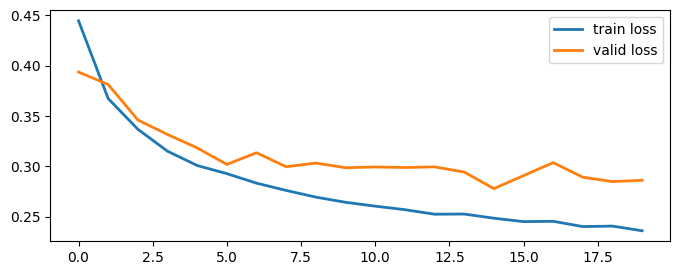

In [36]:
plot_trainval_loss(train_loss, valid_loss)

In [37]:
test_epoch_loss, evaluation = evaluate_epoch(model, test_dataloader, criterion, device)
print(f'test_loss = {test_epoch_loss:<8.4f}')
print_evaluation(*evaluation)

test_loss = 0.2698  
   hamming_loss: 0.1146
   ranking_loss: 0.0884
 coverage_error: 0.2580
      one_error: 0.2448
  avg_precision: 0.7528


## Comparison Experiment on shallow model

In [176]:
def train_model(
        model, train_dataloader, valid_dataloader, criterion, optimizer, 
        num_epoch=100, device='cpu', mixup=False, verbose=True
    ):
    train_loss = []
    valid_loss = []

    for epoch in tqdm(range(num_epoch), leave=False):
        train_epoch_loss = train_epoch(model, train_dataloader, criterion, optimizer, device, mixup=mixup)
        valid_epoch_loss, _ = evaluate_epoch(model, valid_dataloader, criterion, device)

        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        
        if verbose:
            print(
                f'epoch {epoch:>2d}, '
                f'train_loss = {train_epoch_loss:8>.4f}, '
                f'valid_loss = {valid_epoch_loss:8>.4f}'
            )
    
    return train_loss, valid_loss
    

In [39]:
def eval_model(model, test_dataloader, criterion, train_loss, valid_loss, device='cpu'):
    plot_trainval_loss(train_loss, valid_loss)
    
    test_epoch_loss, evaluation = evaluate_epoch(model, test_dataloader, criterion, device)
    print(f'test_loss = {test_epoch_loss:<8.4f}')
    print_evaluation(*evaluation)

In [41]:
model = MlpNet(
    in_features=trainval_dataset.dim_features, 
    out_features=trainval_dataset.dim_labels,
    hidden_layer_sizes=[]
)
model.to(device)

model_nomixup     = copy.deepcopy(model)
model_mixup       = copy.deepcopy(model)
optimizer_nomixup = torch.optim.SGD(model_nomixup.parameters(), lr=0.1)
optimizer_mixup   = torch.optim.SGD(model_mixup.parameters(), lr=0.1)

In [42]:
# train no-mixup model
train_loss_nomixup, valid_loss_nomixup = train_model(
    model_nomixup, train_dataloader, valid_dataloader, criterion, optimizer_nomixup, 
    num_epoch=200, device=device, mixup=False, verbose=False
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [43]:
# train mixup model
train_loss_mixup, valid_loss_mixup = train_model(
    model_mixup, train_dataloader, valid_dataloader, criterion, optimizer_mixup, 
    num_epoch=200, device=device, mixup=True, verbose=False
)

  0%|          | 0/200 [00:00<?, ?it/s]

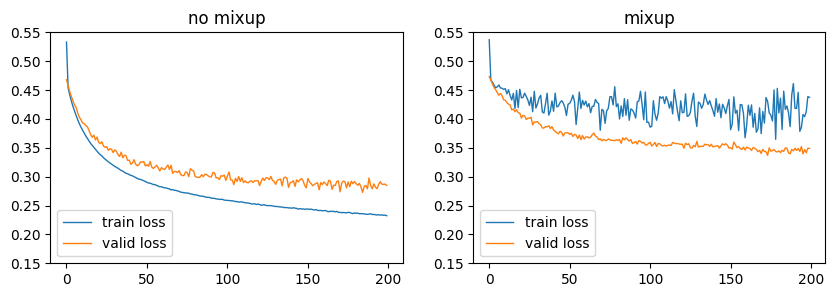

In [44]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(train_loss_nomixup, label='train loss', linewidth=1)
plt.plot(valid_loss_nomixup, label='valid loss', linewidth=1)
plt.ylim(0.15, 0.55)
plt.legend(loc='lower left')
plt.title('no mixup')

plt.subplot(1, 2, 2)
plt.plot(train_loss_mixup, label='train loss', linewidth=1)
plt.plot(valid_loss_mixup, label='valid loss', linewidth=1)
plt.ylim(0.15, 0.55)
plt.legend(loc='lower left')
plt.title('mixup')

plt.show()

In [49]:
print("no mixup:")
print_evaluation(*evaluate_epoch(model_nomixup, test_dataloader, criterion, device)[1])
print("mixup:")
print_evaluation(*evaluate_epoch(model_mixup, test_dataloader, criterion, device)[1])
print("mixup (rescaled):")
print_evaluation(*evaluate_epoch_rescaled(model_mixup, test_dataloader, train_dataloader, criterion, device)[1])

no mixup:
   hamming_loss: 0.1152
   ranking_loss: 0.0866
 coverage_error: 0.2552
      one_error: 0.2517
  avg_precision: 0.7599
mixup:
   hamming_loss: 0.1658
   ranking_loss: 0.0972
 coverage_error: 0.2636
      one_error: 0.2934
  avg_precision: 0.7396
mixup (rescaled):
   hamming_loss: 0.1670
   ranking_loss: 0.0985
 coverage_error: 0.2646
      one_error: 0.2943
  avg_precision: 0.7442


### intermediate conclusion

在 `scene` 多标记学习数据集上, `hidden_layer_sizes=[]` 的 MLP 模型上, 
不使用 mixup 的训练效果更好. 

具体而言, 使用 mixup 时, train loss 的波动起伏更大, train loss 和 valid loss 都更难下降, 
且 valid loss 更早地收敛于较高值. 

一般对于 mixup 的理解是，mixup 是一种类似数据增强的隐式正则化方法，其旨在提升模型的泛化性能，即降低 variance. 

然而在实验中我们观测到 train loss 和 valid loss 的提升，解读为 bias 的增大远远覆盖掉了 variance 的变化.  
猜测原因可能是模型参数量太小，学习能力有限. 

## Comparison Experiment on Deep Model

In [52]:
model = MlpNet(
    in_features=trainval_dataset.dim_features, 
    out_features=trainval_dataset.dim_labels,
    hidden_layer_sizes=[max(trainval_dataset.dim_features, trainval_dataset.dim_labels)]
)
model.to(device)

# dn == deep-no-mixup
# dm == deep-mixup
model_dn     = copy.deepcopy(model)
model_dm     = copy.deepcopy(model)
optimizer_dn = torch.optim.SGD(model_dn.parameters(), lr=0.1)
optimizer_dm = torch.optim.SGD(model_dm.parameters(), lr=0.1)

In [53]:
# train deep no-mixup model
train_loss_dn, valid_loss_dn = train_model(
    model_dn, train_dataloader, valid_dataloader, criterion, optimizer_dn, 
    num_epoch=200, device=device, mixup=False, verbose=False
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [54]:
# train deep mixup model
train_loss_dm, valid_loss_dm = train_model(
    model_dm, train_dataloader, valid_dataloader, criterion, optimizer_dm, 
    num_epoch=200, device=device, mixup=True, verbose=False
)

  0%|          | 0/200 [00:00<?, ?it/s]

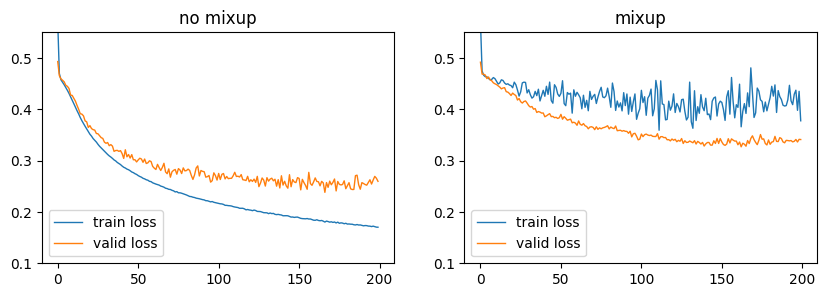

In [55]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(train_loss_dn, label='train loss', linewidth=1)
plt.plot(valid_loss_dn, label='valid loss', linewidth=1)
plt.ylim(0.10, 0.55)
plt.legend(loc='lower left')
plt.title('no mixup')

plt.subplot(1, 2, 2)
plt.plot(train_loss_dm, label='train loss', linewidth=1)
plt.plot(valid_loss_dm, label='valid loss', linewidth=1)
plt.ylim(0.10, 0.55)
plt.legend(loc='lower left')
plt.title('mixup')

plt.show()

In [56]:
print("no mixup:")
print_evaluation(*evaluate_epoch(model_dn, test_dataloader, criterion, device)[1])
print("mixup:")
print_evaluation(*evaluate_epoch(model_dm, test_dataloader, criterion, device)[1])
print("mixup (rescaled):")
print_evaluation(*evaluate_epoch_rescaled(model_dm, test_dataloader, train_dataloader, criterion, device)[1])

no mixup:
   hamming_loss: 0.0969
   ranking_loss: 0.0818
 coverage_error: 0.2509
      one_error: 0.2517
  avg_precision: 0.8070
mixup:
   hamming_loss: 0.1625
   ranking_loss: 0.0896
 coverage_error: 0.2568
      one_error: 0.2778
  avg_precision: 0.7887
mixup (rescaled):
   hamming_loss: 0.1629
   ranking_loss: 0.0919
 coverage_error: 0.2593
      one_error: 0.2812
  avg_precision: 0.7873


### Intermediate Conclusion 

增大参数量后，拟合能力确实增强，deep-no-mixup 模型的表现高于 shallow-no-mixup 模型. 

但是，deep-mixup 的表现依然劣于 deep-no-mixup, train loss 和 valid loss 都下不去. 

## Comparison Experiment with Less Mixup

怀疑问题在于过多使用 mixup sample 而过少使用 standard samples. 

改动训练方法，以 `gamma` 概率启用 mixup, `1 - gamma` 概率不使用 mixup. 

In [200]:
def train_epoch_m2(model, dataloader, criterion, optimizer, device='cpu', mixup=False, alpha=0.2, gamma=0.2):
    model.train()
    epoch_loss = []
        
    for X, Y in dataloader:
        X, Y = X.to(device), Y.to(device)
        Y = Y.squeeze().to(torch.float32)

        # print(f'{next(model.parameters()).device = }')
        # print(f'{device = }')
        
        if mixup and np.random.rand() < gamma:
            # Mixup inputs.
            lambda_ = np.random.beta(alpha, alpha)
            idxs = torch.randperm(X.size(0))
            mixed_X = lambda_ * X + (1 - lambda_) * X[idxs, :]

            # Mixup loss.
            Y_pred = model(X)
            loss = lambda_ * criterion(Y_pred, Y) + (1 - lambda_) * criterion(Y_pred, Y[idxs, :])

        else:
            # no Mixup
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

In [201]:
def train_model_m2(
        model, train_dataloader, valid_dataloader, criterion, optimizer, 
        num_epoch=100, device='cpu', mixup=False, verbose=True, gamma=0.2
    ):
    train_loss = []
    valid_loss = []

    for epoch in tqdm(range(num_epoch), leave=False):
        train_epoch_loss = train_epoch_m2(model, train_dataloader, criterion, optimizer, device, mixup=mixup, gamma=gamma)
        valid_epoch_loss, _ = evaluate_epoch(model, valid_dataloader, criterion, device)

        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        
        if verbose:
            print(
                f'epoch {epoch:>2d}, '
                f'train_loss = {train_epoch_loss:8>.4f}, '
                f'valid_loss = {valid_epoch_loss:8>.4f}'
            )
    
    return train_loss, valid_loss
    

令 `gammma=0.2` 测试

In [78]:
model = MlpNet(
    in_features=trainval_dataset.dim_features, 
    out_features=trainval_dataset.dim_labels,
    hidden_layer_sizes=[max(trainval_dataset.dim_features, trainval_dataset.dim_labels)]
)
model.to(device)

# dn == deep-no-mixup
# dm == deep-mixup
model_dn     = copy.deepcopy(model)
model_dm     = copy.deepcopy(model)
optimizer_dn = torch.optim.SGD(model_dn.parameters(), lr=0.1)
optimizer_dm = torch.optim.SGD(model_dm.parameters(), lr=0.1)

In [ ]:
train_loss_dn, valid_loss_dn = [], []
train_loss_dm, valid_loss_dm = [], []

In [85]:
# train deep no-mixup model
tl, vl = train_model_m2(
    model_dn, train_dataloader, valid_dataloader, criterion, optimizer_dn, 
    num_epoch=200, device=device, mixup=False, verbose=False
)
train_loss_dn += tl
valid_loss_dn += vl

  0%|          | 0/200 [00:00<?, ?it/s]

/hdd/lzm/.conda/envs/multi-label/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [86]:
# train deep mixup model
tl, vl = train_model_m2(
    model_dm, train_dataloader, valid_dataloader, criterion, optimizer_dm, 
    num_epoch=200, device=device, mixup=True, verbose=False
)
train_loss_dm += tl
valid_loss_dm += vl

  0%|          | 0/200 [00:00<?, ?it/s]

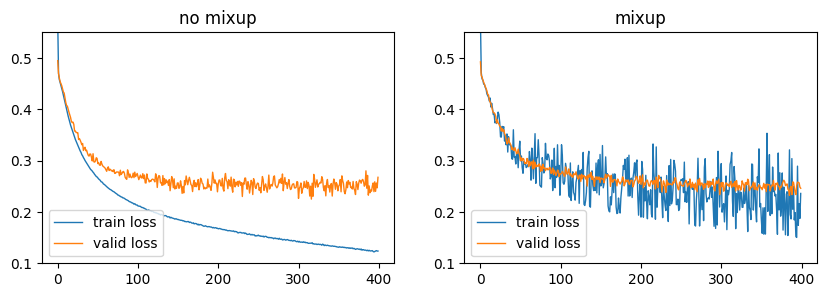

In [87]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(train_loss_dn, label='train loss', linewidth=1)
plt.plot(valid_loss_dn, label='valid loss', linewidth=1)
plt.ylim(0.10, 0.55)
plt.legend(loc='lower left')
plt.title('no mixup')

plt.subplot(1, 2, 2)
plt.plot(train_loss_dm, label='train loss', linewidth=1)
plt.plot(valid_loss_dm, label='valid loss', linewidth=1)
plt.ylim(0.10, 0.55)
plt.legend(loc='lower left')
plt.title('mixup')

plt.show()

In [88]:
print("no mixup:")
print_evaluation(*evaluate_epoch(model_dn, test_dataloader, criterion, device)[1])
print("mixup:")
print_evaluation(*evaluate_epoch(model_dm, test_dataloader, criterion, device)[1])
print("mixup (rescaled):")
print_evaluation(*evaluate_epoch_rescaled(model_dm, test_dataloader, train_dataloader, criterion, device)[1])

no mixup:
   hamming_loss: 0.0952
   ranking_loss: 0.0760
 coverage_error: 0.2468
      one_error: 0.2352
  avg_precision: 0.8119
mixup:
   hamming_loss: 0.0961
   ranking_loss: 0.0783
 coverage_error: 0.2488
      one_error: 0.2431
  avg_precision: 0.8153
mixup (rescaled):
   hamming_loss: 0.0969
   ranking_loss: 0.0811
 coverage_error: 0.2516
      one_error: 0.2474
  avg_precision: 0.8180


### Intermediate Conclusion 

少一点 mixup 固然能让学习效果的下限高一点，但即使如此, mixup 和 no-mixup 效果也只能做到持平，
看不出超越的部分. 

## Comparison Experiment with Deeper Model

怀疑还是因为神经网络不够深, 将神经网络设为 3 层. 

In [93]:
model = MlpNet(
    in_features=trainval_dataset.dim_features, 
    out_features=trainval_dataset.dim_labels,
    hidden_layer_sizes=[
        max(trainval_dataset.dim_features, trainval_dataset.dim_labels),
        max(trainval_dataset.dim_features, trainval_dataset.dim_labels),
        max(trainval_dataset.dim_features, trainval_dataset.dim_labels),
    ]
)
model.to(device)

# d2n == deeper-no-mixup
# d2m == deeper-mixup
model_d2n     = copy.deepcopy(model)
model_d2m     = copy.deepcopy(model)
optimizer_d2n = torch.optim.SGD(model_d2n.parameters(), lr=0.1)
optimizer_d2m = torch.optim.SGD(model_d2m.parameters(), lr=0.1)

In [94]:
train_loss_d2n, valid_loss_d2n = [], []
train_loss_d2m, valid_loss_d2m = [], []

In [108]:
# train deep no-mixup model
tl, vl = train_model_m2(
    model_d2n, train_dataloader, valid_dataloader, criterion, optimizer_d2n, 
    num_epoch=200, device=device, mixup=False, verbose=False
)
train_loss_d2n += tl
valid_loss_d2n += vl

  0%|          | 0/200 [00:00<?, ?it/s]

/hdd/lzm/.conda/envs/multi-label/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [109]:
# train deep mixup model
tl, vl = train_model_m2(
    model_d2m, train_dataloader, valid_dataloader, criterion, optimizer_d2m, 
    num_epoch=200, device=device, mixup=True, verbose=False
)
train_loss_d2m += tl
valid_loss_d2m += vl

  0%|          | 0/200 [00:00<?, ?it/s]

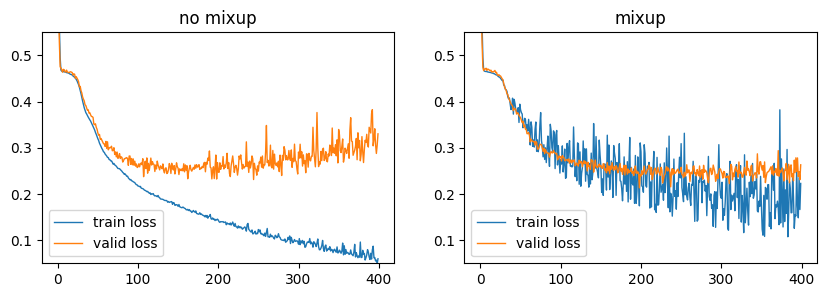

In [111]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(train_loss_d2n, label='train loss', linewidth=1)
plt.plot(valid_loss_d2n, label='valid loss', linewidth=1)
plt.ylim(0.05, 0.55)
plt.legend(loc='lower left')
plt.title('no mixup')

plt.subplot(1, 2, 2)
plt.plot(train_loss_d2m, label='train loss', linewidth=1)
plt.plot(valid_loss_d2m, label='valid loss', linewidth=1)
plt.ylim(0.05, 0.55)
plt.legend(loc='lower left')
plt.title('mixup')

plt.show()

In [112]:
print("no mixup:")
print_evaluation(*evaluate_epoch(model_d2n, test_dataloader, criterion, device)[1])
print("mixup:")
print_evaluation(*evaluate_epoch(model_d2m, test_dataloader, criterion, device)[1])
print("mixup (rescaled):")
print_evaluation(*evaluate_epoch_rescaled(model_d2m, test_dataloader, train_dataloader, criterion, device)[1])

no mixup:
   hamming_loss: 0.1013
   ranking_loss: 0.0922
 coverage_error: 0.2604
      one_error: 0.2656
  avg_precision: 0.8173
mixup:
   hamming_loss: 0.0897
   ranking_loss: 0.0840
 coverage_error: 0.2535
      one_error: 0.2326
  avg_precision: 0.8233
mixup (rescaled):
   hamming_loss: 0.0945
   ranking_loss: 0.0967
 coverage_error: 0.2658
      one_error: 0.2535
  avg_precision: 0.8146


### Intermediate Conclusion 

观察：
no-mixup 模型的 validation loss 先降后升，呈现出明显的过拟合现象。
mixup 模型的 validation loss 下降后收敛于一定值，不发生过拟合。

既然已经观测到了明显的过拟合现象，那么现在的模型的表达能力应该是过剩的了，可以排除欠拟合的问题。
但是在对比中，mixup 的 validation loss 并未下降到比 no-mixup 的 validation loss 低点更低的位置。
因此，我们可以说，只观测到了 mixup 的抗过拟合能力，没有看到其对模型泛化效果的改善. 


结论：在 scene 数据集上 mixup 并无效果。

mixup 的实验在图像、语音数据、表格等数据集上都汇报了不错的性能提升，因此数据集的类型应该不是原因. 

猜想原因：数据集太小了？

## Comparison Experiment on Different Dataset

In [127]:
def init_dataloaders(trainval_dataset, test_dataset):
    train_sampler, valid_sampler = split_trainval_dataset(trainval_dataset, split_ratio=0.8)
    train_dataloader = DataLoader(trainval_dataset, batch_size=64, sampler=train_sampler, drop_last=True)
    valid_dataloader = DataLoader(trainval_dataset, batch_size=64, sampler=valid_sampler, drop_last=True)
    test_dataloader  = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)
    
    return train_dataloader, valid_dataloader, test_dataloader

In [122]:
print({k for k, v in available_datasets()})

avaliable datasets: {'Yahoo-Entertainment', 'Corel5k', 'tmc2007', 'Birds', 'tmc2007-500', 'delicious', 'Yahoo-Arts', 'Yahoo-Social', 'yeast', 'rcv1subset1', 'Yahoo-Business', 'Yahoo-Computers', 'Enron', 'Yahoo-Society', 'scene', 'mediamill', 'Bibtex', 'Slashdot', 'Yahoo-Education', 'Image', 'Emotions', 'Yahoo-Health', 'Yahoo-Science', 'Yahoo-Reference', 'Yahoo-Recreation', 'rcv1subset5', 'Medical'}


In [124]:
dataset_names = ['scene', 'yeast', 'Birds', 'mediamill', 'Medical', 'Bibtex', 'rcv1subset5']
# dataset_names = ['scene', 'yeast']

In [202]:
def train_model_on_dataset(dataset_name, device='cpu'):
    trainval_dataset = MllDataset(name=dataset_name, divide='train')
    test_dataset = MllDataset(name=dataset_name, divide='test')
    train_loader, valid_loader, test_loader = init_dataloaders(trainval_dataset, test_dataset)
    
    dim_features = trainval_dataset.dim_features
    dim_labels = trainval_dataset.dim_labels
    
    model = MlpNet(
        in_features=trainval_dataset.dim_features, 
        out_features=trainval_dataset.dim_labels,
        hidden_layer_sizes=[
            max(dim_features, dim_labels),
            max(dim_features, dim_labels),
            max(dim_features, dim_labels),
        ]
    )
    model.to(device)

    # d2n == deeper-no-mixup
    # d2m == deeper-mixup
    model_n     = copy.deepcopy(model)
    model_m     = copy.deepcopy(model)
    optimizer_n = torch.optim.SGD(model_n.parameters(), lr=0.1)
    optimizer_m = torch.optim.SGD(model_m.parameters(), lr=0.1)
    
    train_loss_n, valid_loss_n = train_model_m2(
        model_n, train_loader, valid_loader, criterion, optimizer_n, 
        num_epoch=500, device=device, mixup=False, verbose=False, gamma=0.5
    )
    train_loss_m, valid_loss_m = train_model_m2(
        model_m, train_loader, valid_loader, criterion, optimizer_m, 
        num_epoch=500, device=device, mixup=True, verbose=False, gamma=0.5
    )
    
    return train_loss_n, valid_loss_n, train_loss_m, valid_loss_m, model_n, model_m

In [211]:
result = dict()

In [265]:
# dataset_names = ['scene', 'yeast', 'Birds', 'mediamill', 'Medical', 'Bibtex', 'rcv1subset5']
# dataset_names = ['Medical', 'Bibtex', 'rcv1subset5']
dataset_names = ['scene', 'yeast', 'Birds', 'Medical']
# dataset_names = ['Birds']

In [266]:
import warnings
warnings.filterwarnings("ignore")

In [291]:
for name in tqdm(dataset_names, desc='datasets', leave=False):
    print(f"training model on {name} ...")
    
    trainval_dataset = MllDataset(name=name, divide='train')
    test_dataset = MllDataset(name=name, divide='test')
    # train_loader, valid_loader, test_loader = init_dataloaders(trainval_dataset, test_dataset)
    train_sampler, valid_sampler = split_trainval_dataset(trainval_dataset, split_ratio=0.8)    
    train_loader = DataLoader(trainval_dataset, batch_size=64, 
                              sampler=train_sampler, drop_last=True, num_workers=0, pin_memory=True)
    valid_loader = DataLoader(trainval_dataset, batch_size=64, 
                              sampler=valid_sampler, drop_last=True, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=64, 
                              shuffle=True, drop_last=True, num_workers=0, pin_memory=True)
    
    dim_features = trainval_dataset.dim_features
    dim_labels = trainval_dataset.dim_labels
    
    print(f"{len(trainval_dataset) = }")
    print(f"{dim_features = }")
    print(f"{dim_labels = }")
    # hidden_layer_size = 64 if dim_labels < 64 else 256
    
    model = MlpNet(
        in_features=trainval_dataset.dim_features, 
        out_features=trainval_dataset.dim_labels,
        hidden_layer_sizes=[
#             max(dim_labels, 32),
#             max(dim_labels, 32),
        ]
    )
    model.to(device)
    print(model)

    # n == no-mixup
    # m == mixup
    model_n     = copy.deepcopy(model)
    model_m     = copy.deepcopy(model)
    optimizer_n = torch.optim.SGD(model_n.parameters(), lr=0.1)
    optimizer_m = torch.optim.SGD(model_m.parameters(), lr=0.1)
    
    train_loss_n, valid_loss_n = train_model_m2(
        model_n, train_loader, valid_loader, criterion, optimizer_n, 
        num_epoch=500, device=device, mixup=False, verbose=True, gamma=0.5
    )
    train_loss_m, valid_loss_m = train_model_m2(
        model_m, train_loader, valid_loader, criterion, optimizer_m, 
        num_epoch=500, device=device, mixup=True, verbose=True, gamma=0.5
    )
    
    _, eval_n = evaluate_epoch(model_n, test_loader, criterion, device)
    _, eval_m = evaluate_epoch(model_m, test_loader, criterion, device)
    
    result[name] = {
        'no-mixup': {
            'train_loss': train_loss_n, 
            'valid_loss': valid_loss_n,
            'evaluation': eval_n,
            'model': model_n
        }, 
        'mixup': {
            'train_loss': train_loss_m, 
            'valid_loss': valid_loss_m, 
            'evaluation': eval_m,
            'model': model_m
        }
    }

datasets:   0%|          | 0/4 [00:00<?, ?it/s]

training model on scene ...
len(trainval_dataset) = 1211
dim_features = 294
dim_labels = 6


  0%|          | 0/500 [00:00<?, ?it/s]

epoch  0, train_loss = 0.5218, valid_loss = 0.4649
epoch  1, train_loss = 0.4561, valid_loss = 0.4480
epoch  2, train_loss = 0.4442, valid_loss = 0.4397
epoch  3, train_loss = 0.4340, valid_loss = 0.4284
epoch  4, train_loss = 0.4252, valid_loss = 0.4242
epoch  5, train_loss = 0.4171, valid_loss = 0.4157
epoch  6, train_loss = 0.4089, valid_loss = 0.4114
epoch  7, train_loss = 0.4021, valid_loss = 0.3997
epoch  8, train_loss = 0.3953, valid_loss = 0.3957
epoch  9, train_loss = 0.3900, valid_loss = 0.3875
epoch 10, train_loss = 0.3846, valid_loss = 0.3807
epoch 11, train_loss = 0.3795, valid_loss = 0.3807
epoch 12, train_loss = 0.3749, valid_loss = 0.3707
epoch 13, train_loss = 0.3707, valid_loss = 0.3719
epoch 14, train_loss = 0.3660, valid_loss = 0.3702
epoch 15, train_loss = 0.3625, valid_loss = 0.3615
epoch 16, train_loss = 0.3586, valid_loss = 0.3640
epoch 17, train_loss = 0.3557, valid_loss = 0.3565
epoch 18, train_loss = 0.3518, valid_loss = 0.3559
epoch 19, train_loss = 0.3488, 

epoch 160, train_loss = 0.2486, valid_loss = 0.2701
epoch 161, train_loss = 0.2485, valid_loss = 0.2665
epoch 162, train_loss = 0.2481, valid_loss = 0.2590
epoch 163, train_loss = 0.2490, valid_loss = 0.2584
epoch 164, train_loss = 0.2482, valid_loss = 0.2585
epoch 165, train_loss = 0.2487, valid_loss = 0.2574
epoch 166, train_loss = 0.2476, valid_loss = 0.2597
epoch 167, train_loss = 0.2475, valid_loss = 0.2544
epoch 168, train_loss = 0.2473, valid_loss = 0.2627
epoch 169, train_loss = 0.2473, valid_loss = 0.2578
epoch 170, train_loss = 0.2473, valid_loss = 0.2547
epoch 171, train_loss = 0.2460, valid_loss = 0.2673
epoch 172, train_loss = 0.2463, valid_loss = 0.2636
epoch 173, train_loss = 0.2462, valid_loss = 0.2572
epoch 174, train_loss = 0.2459, valid_loss = 0.2582
epoch 175, train_loss = 0.2465, valid_loss = 0.2593
epoch 176, train_loss = 0.2455, valid_loss = 0.2545
epoch 177, train_loss = 0.2451, valid_loss = 0.2525
epoch 178, train_loss = 0.2449, valid_loss = 0.2524
epoch 179, t

KeyboardInterrupt: 

In [322]:
import profile

In [351]:
DataLoader?

In [352]:
test_loader._dataset_kind

0

In [342]:
test_dataset = MllDataset(name=name, divide='test')
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True, 
                          drop_last=True, num_workers=0, pin_memory=False)

import math
indices = np.arange(len(test_dataset))
np.random.shuffle(indices)
batch_size = 64
iter_per_epoch = int(math.ceil(len(test_dataset) / batch_size))

In [343]:
def l1():
    for X, Y in test_loader:
        pass
    
def l2():
    for i in range(iter_per_epoch):
        start_idx = (i * batch_size) % len(test_dataset)
        idx = indices[start_idx: start_idx + batch_size]

        X, Y = test_dataset[idx]
        pass

In [344]:
import cProfile

In [345]:
cProfile.run("l1()", filename='result1.out')
cProfile.run("l2()", filename='result2.out')

In [346]:
!ls

0920.ipynb  1011.ipynb	   PLAIN_official_code	result2.out
0927.ipynb  leemultilearn  result1.out		result.out


In [349]:
st = time.time()
for X, Y in test_loader:
    pass
ed = time.time()

print(f"by dataloader: time cost: {ed - st:.4f}s")

by dataloader: time cost: 1.2125s


In [350]:
st = time.time()
for i in range(iter_per_epoch):
    start_idx = (i * batch_size) % len(test_dataset)
    idx = indices[start_idx: start_idx + batch_size]
    
    X, Y = test_dataset[idx]
    pass

ed = time.time()
print(f"by indexing: time cost: {ed - st:.4f}s")

by indexing: time cost: 0.0195s


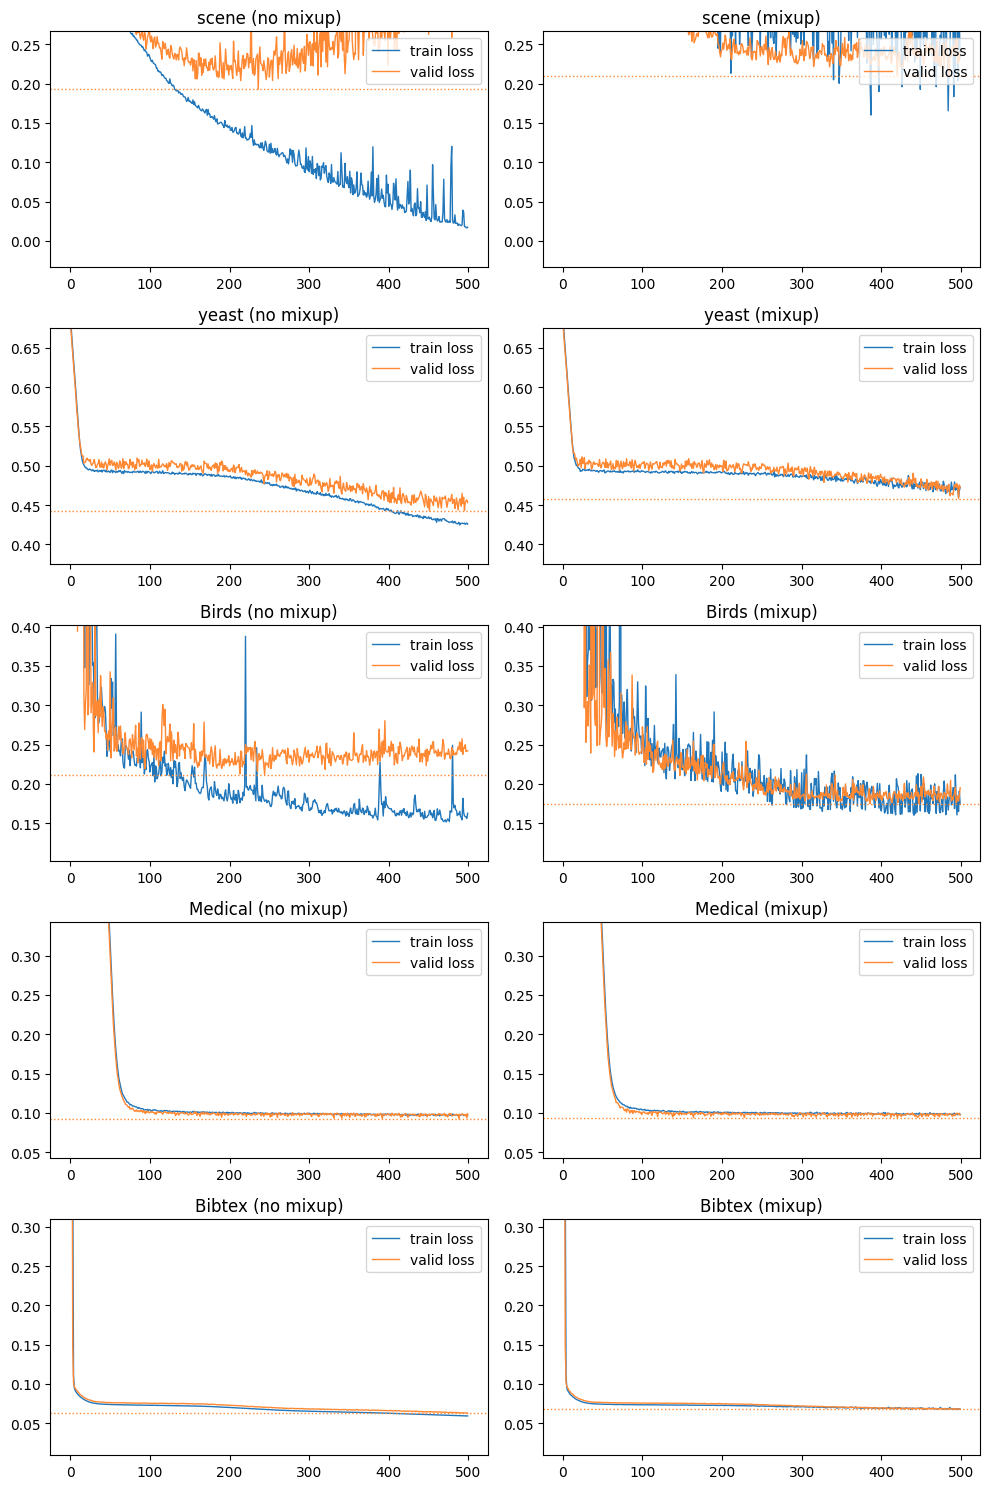

In [273]:
num_datasets = len(result.keys())

plt.figure(figsize=(10, num_datasets * 3))

for i, name in enumerate(result.keys()):
    train_loss_n = result[name]['no-mixup']['train_loss']
    valid_loss_n = result[name]['no-mixup']['valid_loss']
    train_loss_m = result[name]['mixup']['train_loss']
    valid_loss_m = result[name]['mixup']['valid_loss']
    
    all_loss = train_loss_n + valid_loss_n + train_loss_m + valid_loss_m

    plt.subplot(num_datasets, 2, i * 2 + 1)
    plt.plot(train_loss_n, label='train loss', linewidth=1, color='#27B')
    plt.plot(valid_loss_n, label='valid loss', linewidth=1, color='#F83')
    # plt.ylim(min(all_loss) - 0.05, max(all_loss) + 0.05)
    plt.ylim(min(all_loss) - 0.05, min(all_loss) + 0.25)
    plt.legend(loc='upper right')
    plt.axhline(min(valid_loss_n), linestyle=':', linewidth=1, color='#F83')
    plt.title(f'{name} (no mixup)')

    plt.subplot(num_datasets, 2, i * 2 + 2)
    plt.plot(train_loss_m, label='train loss', linewidth=1, color='#27B')
    plt.plot(valid_loss_m, label='valid loss', linewidth=1, color='#F83')
    # plt.ylim(min(all_loss) - 0.05, max(all_loss) + 0.05)
    plt.ylim(min(all_loss) - 0.05, min(all_loss) + 0.25)
    plt.legend(loc='upper right')
    plt.axhline(min(valid_loss_m), linestyle=':', linewidth=1, color='#F83')
    plt.title(f'{name} (mixup)')

plt.tight_layout()
plt.show()

In [250]:
print(f'{"dataset":<12s} {"model":<12s} {"hamming_lss":<12s} {"ranking_lss":<12s} {"coverage_err":<12s} {"one_err":<12s} {"avg_precision":<12s}')
print('-' * 100)

for i, name in enumerate(result.keys()):
    eval_n = result[name]['no-mixup']['evaluation']
    eval_m = result[name]['mixup']['evaluation']
    print(f'{name:<12s} {"no-mixup":<12s} {eval_n[0]:<12.4f} {eval_n[1]:<12.4f} {eval_n[2]:<12.4f} {eval_n[3]:<12.4f} {eval_n[4]:<12.4f}')
    print(f'{name:<12s} {"mixup":<12s} {eval_m[0]:<12.4f} {eval_m[1]:<12.4f} {eval_m[2]:<12.4f} {eval_m[3]:<12.4f} {eval_m[4]:<12.4f}')
    print('-' * 90)

dataset      model        hamming_lss  ranking_lss  coverage_err one_err      avg_precision
----------------------------------------------------------------------------------------------------
scene        no-mixup     0.0897       0.0775       0.2480       0.2335       0.8204      
scene        mixup        0.0913       0.0797       0.2504       0.2344       0.8345      
------------------------------------------------------------------------------------------
yeast        no-mixup     0.2042       0.1807       0.5410       0.2310       0.4630      
yeast        mixup        0.2137       0.1842       0.5289       0.2522       0.4545      
------------------------------------------------------------------------------------------
Birds        no-mixup     0.0645       0.3662       0.4179       0.8719       0.1005      
Birds        mixup        0.0513       0.1516       0.2308       0.8688       0.1351      
-------------------------------------------------------------------------------

## Conclusion

从目前的测试结果来看，在 MLP 上暂时不知道如何让 mixup 发挥效果. 

可能的继续尝试方向包括:

1. 进一步缩减训练集样本数量
2. 使用 CNN，在 MS-COCO, CIFAR 等图像数据集上测试

# Multi-label Baselines